1. Importar librerias a usar durante el código:

In [40]:
import numpy as np                            # Para computación científica.
import matplotlib.pyplot as plt               # Para gráficos.

2. Definir parámetros físicos de la bomba y de temperaturas:

Datos técnicos de la bomba:

In [41]:
R = 0.63                                      # [m] Radio interior del tanque.
H = 1.72                                      # [m] Altura del tanque.
V = 0.194                                     # [m^3] Volumen de agua en el tanque.
Q_HP_total = 1500                             # [W] Potencia de la bomba.

Temperaturas:

In [42]:
T_0 = 20 + 273.15                             # [K] Temperatura inicial del fluido.
T_inf = 12 + 273.15                           # [K] Temperatura del ambiente exterior.
T_W0 = 20 + 273.15                            # [K] Temperatura inicial de la pared (caliente).

Datos del fluido (agua):

In [43]:
k_f = 0.6                                     # [W/m*K] Conductividad térmica del agua.
c_p_f = 4180                                  # [J/kg*K] Calor específico del agua.
rho_f = 997                                   # [kg/m^3] Densisad del agua.
alpha_f = k_f / (rho_f * c_p_f)               # [m^2/s] Difusividad térmica del agua.

Datos de la pared de la bomba (acero):

In [44]:
k_w = 50                                      # [W/m*K] Conductividad térmica del acero.
c_p_w = 466                                   # [J/kg*K] Calor específico del acero.
rho_w = 8000                                  # [kg/m^3] Densisad del acero.
alpha_w = k_w / (rho_w * c_p_w)               # [m^2/s] Difusividad térmica del acero.

Coeficientes de convección:

In [45]:
h_WE = 2.2                                    # [W/m^2*K] Convección pared-ambiente (del paper).
h_WF = 23.83                                  # [W/m^2*K] Convección fluido-pared (cálculo) (h_conv_natural).

3. Definir parámetros de simulación:

In [46]:
n_z = 100                                     # Nodos.
z = np.linspace(0, H, n_z)                    # Crear un dominio discretizado, donde z[0] = 0 y z[-1] = H.
dz = H / (n_z - 1)                            # Espaciamiento o paso de altura.
alpha_max = max(alpha_f, alpha_w)             # Limite de difusividad máxima.   
FO = 0.05                                     # Número de Fourier, para estabilidad de función.
dt = (FO * dz ** 2) / alpha_max               # Paso de tiempo.

Geometría de la bomba:

In [47]:
H_sepentin = 0.25 * H                         # [m] Altura ocupada por el serpentín de la bomba (por ejemplo, 1/4 inferior del tanque).
nodo_serpentin = z >= H_sepentin              # Máscara de nodos de pared donde hay serpentín.
A_lateral_f = 2 * np.pi * R * H               # [m^2] Área lateral total.
A_transversal_f = V / H                       # [m^2] Área de sección transversal del fluido.
V_F = A_transversal_f * dz                    # [m^3] Volumen fluido por nodo.
A_lateral_total = 2 * np.pi * R * H           # [m^2] Área lateral total.
# Área de sección transversal del fluido
V_wall_total= 0.003                           # [m^3] Aproximadamente el volumen de acero.
V_W = V_wall_total / n_z                      # [m^3] Volumen de pared por nodo, repartimos el volumen de pared uniformemente.
V_W_serpentin = V_W * np.sum(nodo_serpentin)  # [m^3] Volumen de pared en la zona del serpentín.
S_HP_W = Q_HP_total / (rho_w * c_p_w * V_W_serpentin) # [K/s] Fuente volumétrica en la pared por la bomba 

4. Definir matrices que se utilizarán en la resolución del problema:

In [48]:
A_F = np.zeros((n_z, n_z))                              # Creación de matriz para fluído vacía.
A_W = np.zeros((n_z, n_z))                              # Creación de matriz para pared vacía.
for i in range(1, n_z - 1):                             # Definir forma de discretización en los nodos interiores (0 < z <H).        
    A_F[i, i - 1] =  alpha_f / dz ** 2                  # Hacia la izquierda, matriz fluido.
    A_F[i, i]   = -2 * alpha_f / dz ** 2                # Central, matriz fluido.
    A_F[i, i + 1] =  alpha_f / dz ** 2                  # Hacia la derecha, matriz fluido.

    A_W[i, i - 1] =  alpha_w / dz ** 2                  # Hacia la izquierda, matriz pared.
    A_W[i, i]   = -2 * alpha_w / dz ** 2                # Central, matriz pared.
    A_W[i, i + 1] =  alpha_w / dz ** 2                  # Hacia la derecha, matriz pared.

5. Con matrices creadas, definir condiciones de borde del problema:

In [49]:
# Condiciones de borde:(∂T/∂z = 0)
# z = 0
A_F[0, 0] = -2 * alpha_f / dz ** 2
A_F[0, 1] =  2 * alpha_f / dz ** 2
A_W[0, 0] = -2 * alpha_w / dz ** 2
A_W[0, 1] =  2 * alpha_w / dz ** 2

#Condiciones de borde:(∂T/∂z = 0)
# z = H
A_F[-1, -1] = -2 * alpha_f / dz ** 2
A_F[-1, -2] =  2 * alpha_f / dz ** 2
A_W[-1, -1] = -2 * alpha_w / dz ** 2
A_W[-1, -2] =  2 * alpha_w / dz ** 2

6. Definir volumenes y áreas por nodo para los términos de convección:

In [50]:
# Área lateral por "rebanada" en z
A_lateral_dz = 2 * np.pi * R * dz         # Área fluido-pared por nodo.
A_lateral_pared_dz = A_lateral_dz         # Asumimos misma área hacia el ambiente.

7. Definir condiciones de la simulación:

In [51]:
T_F = np.ones(n_z) * T_0                  # Condición inicial de temperatura del fluido.
T_W = np.ones(n_z) * T_W0                 # Condición inicial de temperatura de la pared.

write_interval = 3600 * 2                 # Guardar datos cada 2 horas.
t_vec   = []                              # Vector que guarda los tiempos.
T_F_hist = []                             # Vector que guarda las temperaturas del fluido.
T_W_hist = []                             # Vector que guarda las temperaturas de la pared.
T_num= []                                 # Vector que guarda suma de temperaturas.
t = 0                                     # Tiempo de la simulación parte en t = 0.
T_seteada = 65 + 273.15                   # Temperatura máxima que se busca alcanzar.
t_max = 8 * 3600 + 59 * 60                # Tiempo en que se realiza la simulación.

8. Resolución numérica del problema:

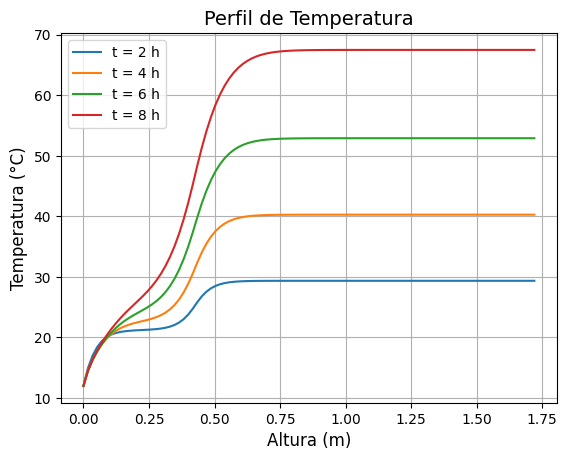

In [ ]:
T_old_F = np.copy(T_F)                    # Crear copia de T_F para que luego ese vector se pueda actualizar durante las iteraciones.
T_old_W = np.copy(T_W)                    # Crear copia de T_W para que luego ese vector se pueda actualizar durante las iteraciones.
T_max_hist = 0                            # Variable para guardar valor máximo que se alcanza de temperatura.
t_max_hist = 0                            # Variable para guardar el tiempo en que se alcanzó la temperatura máxima registrada.
while t < t_max:                                                   # Iteración desde t = 0 hasta t_max.
    dif_T = T_seteada - np.max(T_F)                            # Calcular diferencia entre la temperatura buscada y la temperatura actual del fluido. ###

    # Actualizar nodos interiores para el fluido (con términos q_wf_F, q_wf_W, q_we_W)
    q_wf_F = h_WF * A_lateral_dz * (T_W - T_F) / (rho_f * c_p_f * V_F)              # Calor por convección que gana el fluido por la pared.
    q_wf_W = h_WF * A_lateral_dz * (T_F - T_W) / (rho_w * c_p_w * V_W)              # Calor por convección que gana/pierde la pared por el fluido.
    q_we_W = h_WE * A_lateral_pared_dz  * (T_inf - T_W) / (rho_w * c_p_w * V_W)     # Perdida de calor por convección hacia el ambiente.

    dT_F = np.dot(A_F, T_F) + q_wf_F                                                # Actualización para el fluido: Conducción + convección con pared.
    dT_W = np.dot(A_W, T_W) + q_wf_W - q_we_W                                       # Actualización para la pared: Conducción + convección con fluido + pérdidas al ambiente.

    if (dif_T)/(T_seteada)>0.6:                                                     # Añadir calentamiento de la bomba en la zona del serpentín.
        dT_W[nodo_serpentin] += S_HP_W * (dif_T/T_seteada)
    else:
         dT_W[nodo_serpentin] += S_HP_W*0.4

    T_F_new = T_F + dT_F * dt                                                       # Nuevo valor de T_F.
    T_W_new = T_W + dT_W * dt                                                       # Nuevo valor de T_W.

    T_F_new[0] = T_inf                                                              # Temperatura en la entrada.
    
    T_F = T_F_new                                                                   # Actualizar valor de T_F con su nuevo valor.
    T_W = T_W_new                                                                   # Actualizar valor de T_W con su nuevo valor.
    t += dt                                                                         # Avanzar durante el tiempo con espaciamiento definido dt.
    
    if np.max(T_F_new) > T_max_hist:                                                # Guardar resultados de la temperatura máxima y el tiempo en que esta se alcanzó.
        T_max_hist = np.max(T_F_new)
        t_max_hist = t
    if (t % write_interval) < dt:                                                   # Guardado para poder graficar. Cada write_interval segundos se guarda el perfil T_F_new.
        T_num.append(np.copy(T_F_new))
        t_vec.append(t)

for i in range(len(t_vec)):                                                         # Iterar sobre perfiles guardados y graficar uno por uno.
    tiempo = t_vec[i] / 3600
    perfil_T = T_num[i]
    plt.plot(z, perfil_T - 273.15, label=f't = {tiempo:.0f} h')

# Realizar gráfico con los plots generados durante la iteración.
plt.xlabel('Altura (m)', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.title('Perfil de Temperatura', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

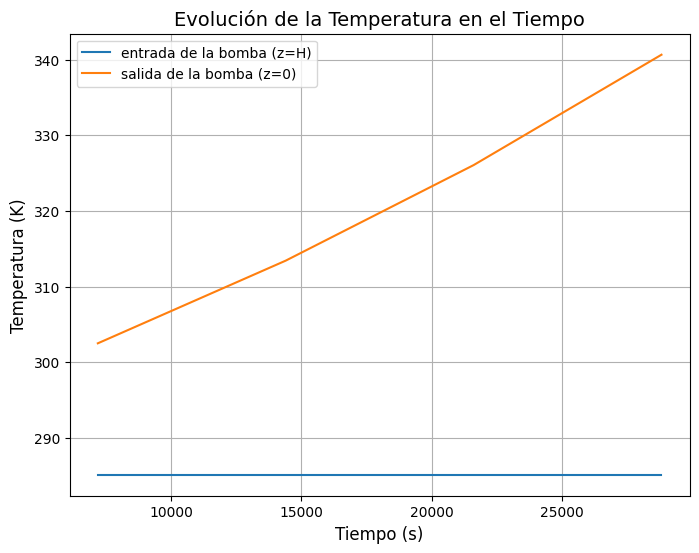

In [53]:
T_entrada= [perfil[0] for perfil in T_num]              # z = 0 (parte inferior)
T_salida= [perfil[-1] for perfil in T_num]              # z = H (parte superior)

plt.figure(figsize=(8, 6))

plt.plot(t_vec, T_entrada, label='entrada de la bomba (z=H)')
plt.plot(t_vec, T_salida, label='salida de la bomba (z=0)')

plt.xlabel('Tiempo (s)', fontsize=12)
plt.ylabel('Temperatura (K)', fontsize=12)
plt.title('Evolución de la Temperatura en el Tiempo', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()